<span style='color:darkcyan'><font size="3">__Juan Sebastian Deslarzes__</font></span><br>
<span style='color:steelblue'><font size="3">__Chloé De Ancos__</font></span><br>
<span style='color:darkcyan'><font size="3">__Anaïs Burrus__</font></span><br>
<span style='color:darkcyan'><font size="3">__Margot Chapot__</font></span><br>
<span style='color:darkcyan'><font size="3">__Eva Sarlin__</font></span><br>

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as np
from skimage import io
from IPython import display
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(color_codes=True)

Loading BokehJS ...

<span style='color:mediumpurple'><font size="6">__Data Loading__</font></span><br>

In [11]:
sample_submission_url = 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/sample_submission.csv'
test_nolabel_url= 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/test_nolabel.csv'
train_url = 'https://raw.githubusercontent.com/esarlin/Challenge-2-CDAW/main/sitc-challenge2-2022/train.csv'

sample_submission = pd.read_csv(sample_submission_url)
test_nolabel = pd.read_csv(test_nolabel_url)
train = pd.read_csv(train_url)

<span style='color:mediumpurple'><font size="6">__Data Visualization__</font></span><br>

In [12]:
train.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


In [22]:
print('Data train dimensions : ', train.shape)
print('Unique values for label : ', train['label'].unique())
print("Number of unique values for statement: ", train['statement'].unique().size)
print("Number of unique values for subject: ", (train['subject'].unique()).size)
print("Number of unique values for speaker: ", (train['speaker'].unique()).size)
print("Number of unique values for speaker job: ", (train['speaker_job'].unique()).size)
print("Number of unique values for state information: ", (train['state_info'].unique()).size)
print("Number of unique values for party affiliation: ", (train['party_affiliation'].unique()).size)

Data train dimensions :  (8950, 8)
Unique values for label :  [1 0]
Number of unique values for statement:  8939
Number of unique values for subject:  3409
Number of unique values for speaker:  2634
Number of unique values for speaker job:  1092
Number of unique values for state information:  80
Number of unique values for party affiliation:  24


<AxesSubplot:xlabel='label', ylabel='party_affiliation'>

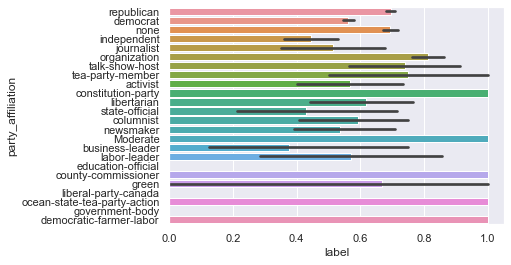

In [15]:
sns.barplot(x='label', y='party_affiliation', data=train)

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION DATA VISUALIZATION</b></font></span><br><br> <span style='color:black'> Donc en gros, on a un dataset de 8950 instances avec 8 colonnes. On peut y voir 7 features et 1 label/étiquette qui est la deuxième colonne "label". On doit rendre un un fichier submission avec les id et les label. L'objectif du challenge est donc de classifier en prédictant le label du fichier test_nolabel. On peut voir que la problème est le grand nombre de valeurs uniques pour une grande partie des attributs. Cela est du au fait que cette fois les valeurs des features sont du texte. L'objectif est donc de process ces valeurs textuelles pour pourvoir ensuite les uiliser avec des algo de machine learning. </span>
</div>

<span style='color:mediumpurple'><font size="6">__NLP algorithms (process les strings)__</font></span><br>

<span style='color:steelblue'><font size="3">__Avec le code du lab nlp (accuracy calculée sur le train)__</font></span><br>

In [24]:
X = train['statement'].values
y = train['label'].values

In [25]:
# Generic Transformer 
from sklearn.base import BaseEstimator, TransformerMixin

class GenericTransformer(BaseEstimator, TransformerMixin):

    def transform(self, X, y=None):
        return do_something_to(X, self.vars)  # where the actual feature extraction happens

    def fit(self, X, y=None):
        return self  # used if the feature requires training, for example, clustering

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize

class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='english')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

def custom_tokenizer(words):
    """Preprocessing tokens as seen in the lexical notebook"""
    tokens = word_tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    stoplist = stopwords.words('english')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    return lemmas_punct

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import pos_tag
from collections import Counter 

class PosStats(BaseEstimator, TransformerMixin):
    """Obtain number of tokens with POS categories"""

    def stats(self, doc):
        tokens = custom_tokenizer(doc)
        tagged = pos_tag(tokens, tagset='universal')
        counts = Counter(tag for word,tag in tagged)
        total = sum(counts.values())
        #copy tags so that we return always the same number of features
        pos_features = {'NOUN': 0, 'ADJ': 0, 'VERB': 0, 'ADV': 0, 'CONJ': 0, 
                        'ADP': 0, 'PRON':0, 'NUM': 0}
        
        pos_dic = dict((tag, float(count)/total) for tag,count in counts.items())
        for k in pos_dic:
            if k in pos_features:
                pos_features[k] = pos_dic[k]
        return pos_features
    
    def transform(self, docs, y=None):
        return [self.stats(doc) for doc in docs]
    
    def fit(self, docs, y=None):
        """Returns `self` unless something different happens in train and test"""
        return self

In [29]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), encoding = 'ISO-8859-1', 
                                        tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation



## All the steps of the Pipeline should end with a sparse vector as the input data

pipeline = Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    ('pos_stats', Pipeline([
                                ('pos_stats', PosStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_components=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
       
        ('clf', MultinomialNB(alpha=.01))  # classifier
    ])

# Using KFold validation

cv = KFold(2, shuffle=True, random_state=33)
scores = cross_val_score(pipeline, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [0.60581006 0.59396648]
Accuracy: 0.60 (+/- 0.01)


<span style='color:steelblue'><font size="3">__Avec un autre code__</font></span><br>

In [33]:
import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
import pickle
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evasarlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=1000, random_state=0)

In [44]:
y_pred = classifier.predict(X_test)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 134  489]
 [ 123 1044]]
              precision    recall  f1-score   support

           0       0.52      0.22      0.30       623
           1       0.68      0.89      0.77      1167

    accuracy                           0.66      1790
   macro avg       0.60      0.55      0.54      1790
weighted avg       0.63      0.66      0.61      1790

0.6581005586592179


<span style='color:steelblue'><font size="3">__Prédiction du test kaggle :__</font></span><br>

In [66]:
X_test = test_nolabel['statement'].values

In [68]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X_test)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X_test[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [69]:
X_test = vectorizer.fit_transform(documents).toarray()
X_test = tfidfconverter.fit_transform(X_test).toarray()

In [71]:
y_predicted=classifier.predict(X_test)

<span style='color:mediumpurple'><font size="6">__Feature Engineering__</font></span><br>

<span style='color:steelblue'><font size="5">__Statement Processing__</font></span><br>

<span style='color:steelblue'><font size="5">__Subject processing__</font></span><br>

<span style='color:steelblue'><font size="5">__Speaker features processing__</font></span><br>

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION DATA EXPLORING</b></font></span><br><br> <span style='color:black'> ici on écrit les conclusions, on peut même écrire en italique <i>voili </i>voilou. </span>
</div>

<span style='color:mediumpurple'><font size="6">__Machine Learning Algorithm__</font></span><br>

<span style='color:steelblue'><font size="5">__Ensemble Algos__</font></span><br>

<span style='color:steelblue'><font size="5">__Deep Learning__</font></span><br>

<span style='color:steelblue'><font size="5">__Genetic Algorithm__</font></span><br>

<div class="alert alert-block alert-info">
    <span style='color:darkblue'><font size="4"><b>CONCLUSION ALGORITHMS</b></font></span><br><br> <span style='color:black'> ici on écrit les conclusions, on peut même écrire en italique <i>voili </i>voilou. </span>
</div>

<span style='color:mediumpurple'><font size="6">__Submission__</font></span><br>

In [74]:

id = test_nolabel['id']
dfsubmission = pd.DataFrame({'id': id, 'label': y_predicted}, columns=["id", "label"])
dfsubmission.to_csv('submission1.csv', index=False, header=True)

<div class="alert alert-block alert-info">
    <span style='color:purple'><font size="4"><b>CONCLUSION GENERALE</b></font></span><br><br> <span style='color:black'> ici on écrit les conclusions, on peut même écrire en italique <i>voili </i>voilou. </span>
</div>